In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

from pmdarima import auto_arima 

import warnings
warnings.filterwarnings("ignore")

This notebook is going to explore classic forecasting techniques on the [Carbon Dioxide Dataset](https://www.kaggle.com/datasets/ucsandiego/carbon-dioxide/data).


This dataset displays seasonality, so it will be a good application for SARIMA modeling. I will consider a more common approach by using pmdarima, and then also a newer approach with [StatsForecast](https://github.com/Nixtla/statsforecast). 

In [2]:
df = pd.read_csv('co2.csv')

# make custom date column out of Year and Month
df['date']=pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
date,,,,,,,
1958-01-01,1958,1,1958.0411,NaN,NaN,NaN,NaN
1958-02-01,1958,2,1958.1260,NaN,NaN,NaN,NaN
1958-03-01,1958,3,1958.2027,315.69,314.42,316.18,314.89
1958-04-01,1958,4,1958.2877,317.45,315.15,317.30,314.98
1958-05-01,1958,5,1958.3699,317.50,314.73,317.83,315.06


In [3]:
# there are some missing values, I can interpolate by just using the previous month's value
df['CO2 Interpolated'] = df['Carbon Dioxide (ppm)'].fillna(method='ffill')

# remove Jan and Feb 1958 since there is no data
df = df[~df.index.isin(['1958-01-01', '1958-02-01'])]
# 2017 is mostly incomplete, so I'll drop that too
df = df[df['Year']!= 2017]
df.head()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm),CO2 Interpolated
date,,,,,,,,
1958-03-01,1958,3,1958.2027,315.69,314.42,316.18,314.89,315.69
1958-04-01,1958,4,1958.2877,317.45,315.15,317.30,314.98,317.45
1958-05-01,1958,5,1958.3699,317.50,314.73,317.83,315.06,317.50
1958-06-01,1958,6,1958.4548,NaN,NaN,317.22,315.14,317.50
1958-07-01,1958,7,1958.5370,315.86,315.17,315.87,315.21,315.86


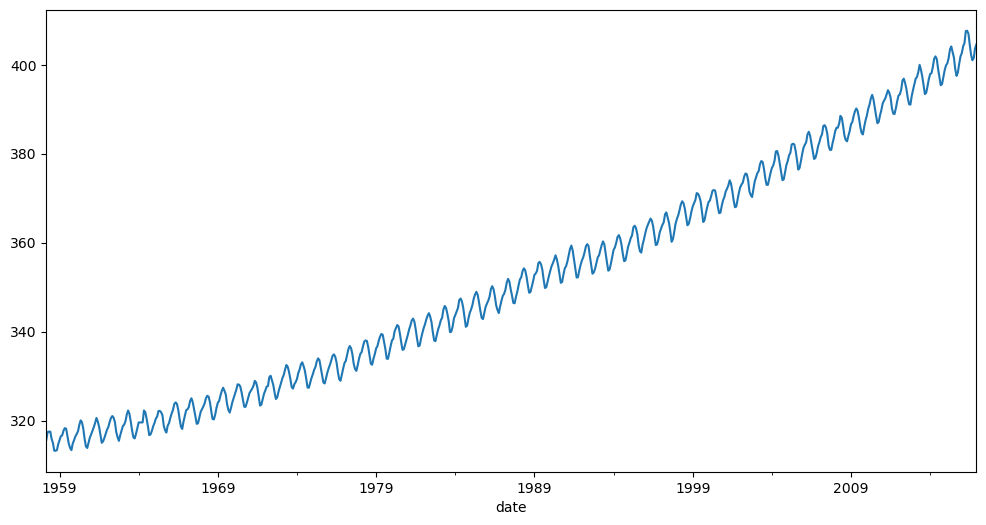

In [4]:
# plot the data
df['CO2 Interpolated'].plot(figsize=(12,6))
plt.show();

Next, I'll run AutoArima to get an optimal fitting SARIMAX model. 

In [5]:
auto_arima(df['CO2 Interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  706
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -246.202
Date:                              Mon, 27 Jan 2025   AIC                            510.403
Time:                                      17:28:16   BIC                            551.427
Sample:                                  03-01-1958   HQIC                           526.256
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.352      0.176      -0.000       0.001
ar.L1          0.0234      0.488      0.048      0.962      -0.932       0.979
ar.L2          0.2239      0.371      0.603      0.546      -0.503       0.951
ma.L1         -0.3527      0.492     -0.716      0.474      -1.318       0.612
ma.L2         -0.2735      0.511     -0.535      0.593      -1.276       0.728
ma.L3         -0.0322      0.116     -0.277      0.782      -0.260       0.196
ar.S.L12       0.9956      0.002    553.943      0.000       0.992       0.999
ma.S.L12      -0.7751      0.032    -23.966      0.000      -0.838      -0.712
sigma2         0.1117      0.005     20.637      0.000       0.101       0.122
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                24.29
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.02
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best fit looks like SARIMAX(2, 1, 3)x(1, 0, [1], 12). Let's split the data and train a model with these parameters.

I want to try to forecast 1 year into the future. A good rule of thumb is to only make your test set as long as the desired forecast horizon.

In [6]:
train = df.iloc[:694]
test = df.iloc[694:]

model = SARIMAX(train['CO2 Interpolated'],order=(2,1,3),seasonal_order=(1,0,1,12))
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35051D+00    |proj g|=  1.32190D+00



 This problem is unconstrained.


At iterate    5    f=  4.96870D-01    |proj g|=  3.55374D-01

At iterate   10    f=  3.60177D-01    |proj g|=  5.70012D-02

At iterate   15    f=  3.45113D-01    |proj g|=  1.33205D-01
  ys=-3.744E-04  -gs= 1.394E-03 BFGS update SKIPPED

At iterate   20    f=  3.42937D-01    |proj g|=  1.96185D-02

At iterate   25    f=  3.42894D-01    |proj g|=  1.18829D-02

At iterate   30    f=  3.42882D-01    |proj g|=  8.30101D-03
  ys=-4.152E-14  -gs= 2.304E-14 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.42874D-01    |proj g|=  1.91908D-02

At iterate   40    f=  3.42812D-01    |proj g|=  7.91877D-03

At iterate   45    f=  3.42812D-01    |proj g|=  7.55915D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  3.42804D-01    |proj g|=  9.07613D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    190      4     2     0   9.076D-03   3.428D-01
  F =  0.34280419920022481     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     CO2 Interpolated   No. Observations:                  694
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -237.906
Date:                              Mon, 27 Jan 2025   AIC                            491.812
Time:                                      17:28:21   BIC                            528.140
Sample:                                  03-01-1958   HQIC                           505.862
                                       - 12-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0436      0.022      2.019      0.044       0.001       0.086
ar.L2          0.9558      0.017     56.235      0.000       0.923       0.989
ma.L1         -0.3999      0.020    -19.534      0.000      -0.440      -0.360
ma.L2         -0.9542      0.018    -53.647      0.000      -0.989      -0.919
ma.L3          0.3550      0.030     11.807      0.000       0.296       0.414
ar.S.L12       0.9962      0.002    660.411      0.000       0.993       0.999
ma.S.L12      -0.7637      0.035    -21.704      0.000      -0.833      -0.695
sigma2         0.1106      0.006     17.918      0.000       0.099       0.123
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                27.44
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.08
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now let's get the predicted values, plot to visually see how well the model fits, and then quantify performance with RMSE.

In [8]:
predictions = results.predict(start=len(train), end=len(df)-1, dynamic=False, typ='levels').rename('SARIMA Predictions')

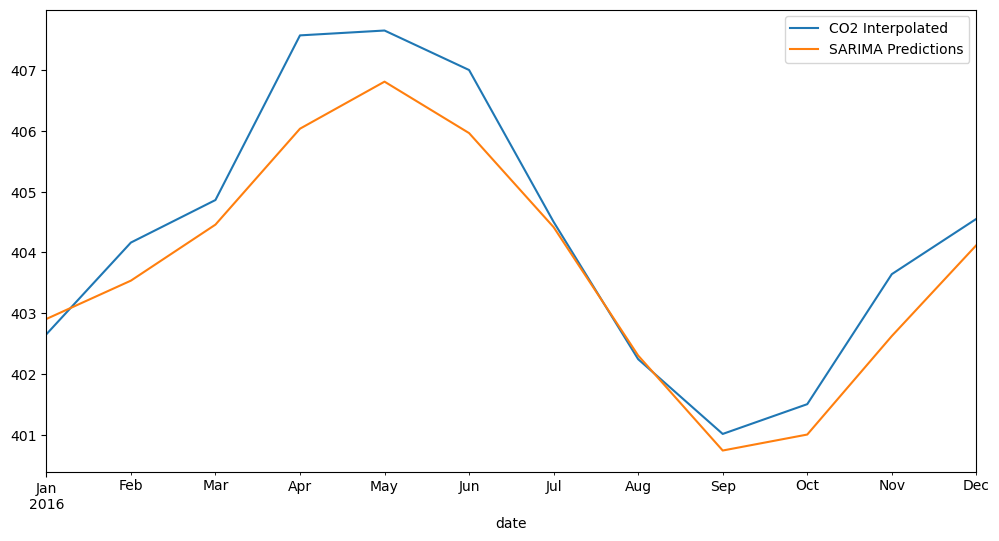

In [9]:
ax = test['CO2 Interpolated'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
plt.show();

In [10]:
error = rmse(test['CO2 Interpolated'], predictions)
print(f'RMSE Error: {error:11.10}')

RMSE Error: 0.726164914


Pretty good results. Now let's forecast into the future. Start by re-training the selected model on all the data, then predict one year into the future.

In [11]:
model = SARIMAX(df['CO2 Interpolated'],order=(2,1,3),seasonal_order=(1,0,1,12))
results = model.fit()

forecasted_results = results.predict(len(df), len(df)+11,typ='levels').rename("SARIMAX Forecast")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37086D+00    |proj g|=  1.31554D+00


 This problem is unconstrained.



At iterate    5    f=  5.12063D-01    |proj g|=  4.07459D-01

At iterate   10    f=  3.79759D-01    |proj g|=  7.97662D-02

At iterate   15    f=  3.61885D-01    |proj g|=  5.66117D-03

At iterate   20    f=  3.59188D-01    |proj g|=  2.38085D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     94      2     0     0   1.831D-02   3.592D-01
  F =  0.35918824793922138     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


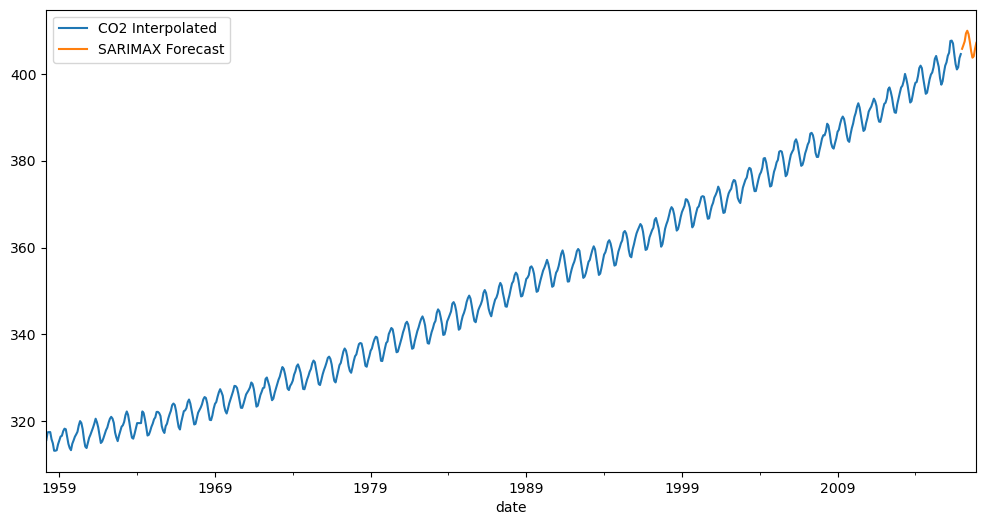

In [12]:
ax = df['CO2 Interpolated'].plot(legend=True,figsize=(12,6))
forecasted_results.plot(legend=True)
plt.show();

This looks like a very reasonable forecast!

***
## StatsForecast

Nothing against pmdarima, but it can be slow! Let's try a similar approach, but with StatForecast. I can also try out different models, with much more speed.

I'll start fresh with a fresh read of the dataset because this module requires the data to be formatted in a specific manner and to reduce the risk of introducing manual error.

In [20]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, HoltWinters
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error

In [14]:
df = pd.read_csv('co2.csv')

# make custom date column out of Year and Month
df['ds']=pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))

# same transformations as above, just re-named.
df['y'] = df['Carbon Dioxide (ppm)'].fillna(method='ffill')

# remove Jan and Feb 1958 since there is no data
df = df[~df['ds'].isin(['1958-01-01', '1958-02-01'])]
# 2017 is mostly incomplete, so I'll drop that too
df = df[df['Year']!= 2017]
df.head()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm),ds,y
2,1958,3,1958.2027,315.69,314.42,316.18,314.89,1958-03-01,315.69
3,1958,4,1958.2877,317.45,315.15,317.30,314.98,1958-04-01,317.45
4,1958,5,1958.3699,317.50,314.73,317.83,315.06,1958-05-01,317.50
5,1958,6,1958.4548,NaN,NaN,317.22,315.14,1958-06-01,317.50
6,1958,7,1958.5370,315.86,315.17,315.87,315.21,1958-07-01,315.86


We can use StatsForecast to try several models at once. From their documentation:

* The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y.

Since I only have 1 time series I care about, I will make a new column for `unique_id` so that the package will run.

In [15]:
df['unique_id'] = 'co2_series'
df = df[['unique_id', 'ds', 'y']]

In [28]:
season_length = 12
sf = StatsForecast(models = [
    AutoARIMA(season_length = 12),
    HoltWinters(season_length = 12, error_type = 'A', alias = 'HoltWinters Addititve'),
    HoltWinters(season_length = 12, error_type = 'M', alias = 'HoltWinters Multiplicative'),
],
    freq = 'MS') 

In [29]:
train = df.iloc[:694]
test = df.iloc[694:]

# fit the model
sf.fit(train)

StatsForecast(models=[AutoARIMA,HoltWinters Addititve,HoltWinters Multiplicative])

Notice how we can fit several models in just about 2 seconds. This is a huge win for StatsForecast.

In [32]:
predictions = sf.predict(h=test['ds'].nunique())
predictions = test.merge(predictions, how = 'left', on = 'ds')

predictions.columns

Index(['unique_id_x', 'ds', 'y', 'unique_id_y', 'AutoARIMA',
       'HoltWinters Addititve', 'HoltWinters Multiplicative'],
      dtype='object')

In [39]:
models = ['AutoARIMA', 'HoltWinters Addititve', 'HoltWinters Multiplicative']

metrics = []
for m in models:
        mape = mean_absolute_percentage_error(predictions['y'], predictions[m])
        rmse = root_mean_squared_error(predictions['y'], predictions[m])
        metrics.append({'Model': m, 'RMSE': rmse, 'MAPE': mape})


# find best performing model for each category using RMSE
metrics = pd.DataFrame(metrics)
metrics.sort_values('RMSE', ascending=True)

,Model,RMSE,MAPE
0,AutoARIMA,0.903100,0.001915
1,HoltWinters Addititve,1.028402,0.002283
2,HoltWinters Multiplicative,1.340618,0.003077


AutoARIMA gives us the lowest RMSE, so let's fit that model on the whole dataset and do some forecasting.

In [41]:
season_length = 12
sf2 = StatsForecast(models = [
    AutoARIMA(season_length = 12),
], freq = 'MS') 

sf2.fit(df)
forecasted_results = sf2.predict(h=12)

In [45]:
# reset indexes for plotting
df.set_index('ds', inplace=True)
forecasted_results.set_index('ds', inplace=True)

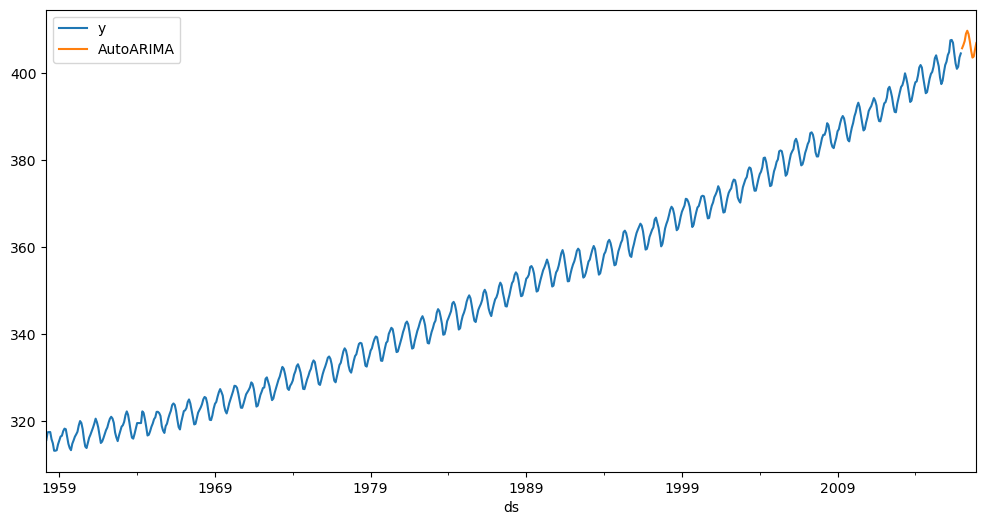

In [49]:
ax = df['y'].plot(figsize=(12,6), legend=True)
forecasted_results.plot(ax=ax, legend=True)
plt.show();